<a href="https://colab.research.google.com/github/kaitlynwarford/mlb-feature-importance-analysis/blob/main/FeatureImportance_Batting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install pybaseball for historical data
!pip install pybaseball

# import packages
import pandas as pd
from pybaseball import batting_stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.8 MB/s eta 0:00:00


In [2]:
# define start and end seasons
start_season = 2015
end_season = 2024

# filter data for qualified players based on plate appearances
historical_data = batting_stats(start_season, end_season, qual=1)

In [3]:
# function to shift WAR to create "Next_WAR" column for each player
def create_next_war_target(player_df):
  player_df = player_df.sort_values('Season')
  player_df['Next_WAR'] = player_df['WAR'].shift(-1)
  return player_df

In [4]:
# apply function to each player group
df_processed = historical_data.groupby('IDfg', group_keys=False).apply(create_next_war_target)

/tmp/ipython-input-1462069950.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_processed = historical_data.groupby('IDfg', group_keys=False).apply(create_next_war_target)


In [5]:
# drop rows where 'Next_WAR' is NaN
df_processed.dropna(subset=['Next_WAR'], inplace=True)

# select features to use in model
features = ['Age', 'G', 'PA', 'AVG', 'OBP', 'SLG', 'OPS', 'wOBA', 'wRC+', 'ISO', 'BABIP']
target = 'Next_WAR'

df_model = df_processed[features + [target]]

In [6]:
# import packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [7]:
# split data into training and testing sets
X = df_model[features]
Y = df_model[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# initialize and train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

# make predicitions on test set
predictions = model.predict(X_test)

In [8]:
# evaluate model
mse = mean_squared_error(Y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, predictions)

print(f'\nModel Performance')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-Squared (R2): {r2:.2f}')

# feature importance analysis
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

print('\nFeature Importance:')
print(feature_importances)


Model Performance
Mean Squared Error (MSE): 1.72
Root Mean Squared Error (RMSE): 1.31
R-Squared (R2): 0.32

Feature Importance:
PA       0.313605
wRC+     0.118706
G        0.085430
Age      0.084758
BABIP    0.069252
OBP      0.066425
AVG      0.062137
ISO      0.060248
SLG      0.052447
wOBA     0.044376
OPS      0.042616
dtype: float64


In [9]:
# import visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

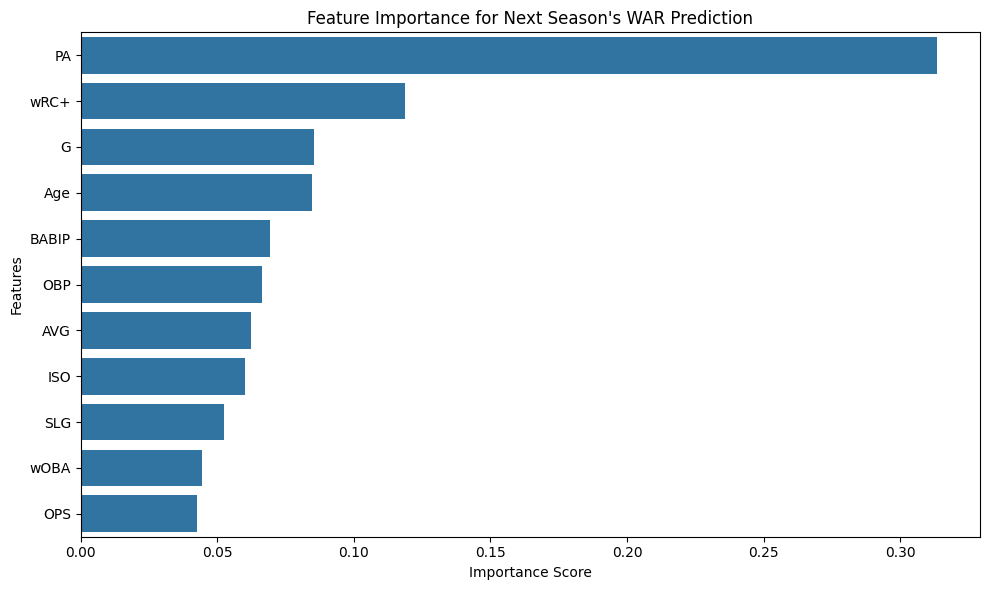

In [10]:
# visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Feature Importance for Next Season's WAR Prediction")
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()